In [32]:
from os import walk

def findTextFiles(readDir):
    d = []
    f = []
    t = []
    c = []
    for (root,dirs,files) in walk(readDir,topdown=True):
        d.extend(dirs)
        f.extend(files)
        for x in f:
            if x.endswith('.txt'):
                t.extend([x])
            elif x.endswith('csv'):
                 c.extend([x])                   
        d = sorted(d)
        t = sorted(t)
        c = sorted(c)
        return(d,t,c)
    
def readUSGS(filename,headerNum):
    df = pd.read_csv(filename, sep='	',header=headerNum,index_col=2)
    df = df.drop(['agency_cd','site_no','tz_cd'],axis=1)
    df = df.drop(['20d'])
    df.index = pd.to_datetime(df.index)
    #rename the parameter columns to better names e.g., y-gage-ft, Q-cfs, rain-in
    # depth always reported as GAGE DEPTH
    parameterNames = ['river elevation', 'resevoir elevation', 'Q-river', 'rain-in']
    parameterList = ['00065','00062','00060','00045']
    for j in range(0,len(df.columns),2):
        #paramterCode format #####_000##
        parameterCode = df.columns[j].split('_',1)[1]
        parameterName = parameterNames[parameterList.index(parameterCode)]
        df = df.rename(columns={df.columns[j] : parameterName, df.columns[j+1] : parameterName + '-Quality'})
        #also make the y, Q, res-el,and/or rain values numeric
        df[df.columns[j]]=df[df.columns[j]].astype('float64')
    return(df)

In [206]:
flowDir = 'P:\\PW-WATER SERVICES\\TECHNICAL SERVICES\\Anna\\Storm Analysis\\FlowData_20190605_20190612'
usgsDir = 'H:\\Big Creek\\USGS River\\June8th'

import pandas as pd

folders,usgsSites,fm2usgs = findTextFiles(usgsDir)

In [216]:
site = usgsSites[4]
'0' + site.split('_')[0].split('S0')[1]
site.startswith('USGS')

headNums = {'02335580' : 29,
            '02335700' : 29,
            '02335757' : 27,
            '02335790' : 30,
            '02335450' : 27,
            '02335810' : 29}
site

'USGS02335790_15min_20190605-20190612.txt'

In [217]:
fn = usgsDir + '\\' + usgsSites[4]
siteNum = '0' + site.split('_')[0].split('S0')[1]
df = readUSGS(filename=fn,headerNum=headNums[siteNum])
df.head()
siteNum

'02335790'

In [211]:
usgsDict = {}
usgsDict[siteNum] = df

In [212]:
usgsDict[siteNum].head()

,rain-in,rain-in-Quality,river elevation,river elevation-Quality,Q-river,Q-river-Quality
datetime,,,,,,
2019-06-05 00:00:00,0.0,P,1.28,P,9.12,P
2019-06-05 00:15:00,0.0,P,1.28,P,9.12,P
2019-06-05 00:30:00,0.0,P,1.28,P,9.12,P
2019-06-05 00:45:00,0.0,P,1.28,P,9.12,P
2019-06-05 01:00:00,0.0,P,1.28,P,9.12,P


In [219]:
df = pd.read_csv(usgsDir + '\\' + fm2usgs[0],index_col=0)
df.head()

,USGSID,Closest,US/DS
FID,,,
BC01,2335790,1,DS
BC01A,2335790,0,US
BC02,2335790,0,US
BC03,2335790,0,US
BC05,2335790,0,US


In [220]:
df.loc['BC03','Closest']

0

In [221]:
def readSliicercsv(filename):
    df = pd.read_csv(filename,index_col = 0,header=2,usecols=[0,1,2,3,4],names=['Datetime','sdepth (in)','y (in)','v (ft/s)','Q (MGD)'])
    df.index = pd.to_datetime(df.index)
    return(df)

flowDir = 'P:\\PW-WATER SERVICES\\TECHNICAL SERVICES\\Anna\\Storm Analysis\\FlowData_20190605_20190612'
f = 'BC03_29880727.csv'
dfflow = readSliicercsv(flowDir+'\\'+f)

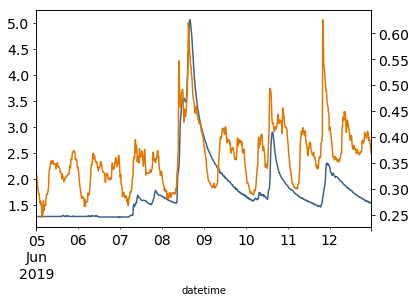

In [215]:
dfriver = usgsDict[siteNum]
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
dfriver['river elevation'].plot(kind='line',ax=ax,fontsize=14,color='xkcd:denim')
flowDir = 'P:\\PW-WATER SERVICES\\TECHNICAL SERVICES\\Anna\\Storm Analysis\\FlowData_20190605_20190612'
ax2 = ax.twinx()
dfflow['Q (MGD)'].plot(kind='line',ax=ax2,fontsize=14,color='xkcd:pumpkin')


In [222]:
def getTimeDiff(date1,date2,returnState):
    date1 = pd.to_datetime(date1)
    date2 = pd.to_datetime(date2)
    if date2 >= date1:
        dateDiff = date2 - date1
    else:
        dateDiff = date1 - date2
    # convert to days and seconds
    days, seconds = dateDiff.days, dateDiff.seconds
    # covert to total hours and total minutes
    hours = days * 24 + seconds // 3600
    minutes = (seconds % 3600) // 60
    returnOptions = {'days': days, 'hours': hours, 'minutes' : minutes, 'seconds' : seconds}
    return(returnOptions[returnState])

def constructMeanFlow(tStart,tEnd,dfMeans):
    daysDiff = getTimeDiff(tStart,tEnd,'days')
    wVals = [(tStart + dt.timedelta(days=x)).weekday() for x in range(0,daysDiff+1)]    
    meanFlow = []
    dateTimes = []
    day = dt.datetime(tStart.year,tStart.month,tStart.day)
    for k in range(0,len(wVals)):
        if wVals[k] > 4: #WEEKEND
            col = 'Weekend'
        else:
            col = 'Weekday'
        if k==0: # pre-comp period
            meanFlow.extend(dfMeans.loc[tStart.time():,col])
            h = getTimeDiff(tStart.date() + dt.timedelta(days=1),tStart,returnState='hours')
            m = getTimeDiff(tStart.date() + dt.timedelta(days=1),tStart,returnState='minutes')
            dateTimes.extend([tStart + dt.timedelta(minutes=x) for x in range(0,h*60 + m,15)])
        elif k==len(wVals)-1: # end of r2
            meanFlow.extend(dfMeans.loc[:tEnd.time(),col])
            h = getTimeDiff(tEnd,tEnd.date(),returnState='hours')
            m = getTimeDiff(tEnd,tEnd.date(),returnState='minutes')
            dateTimes.extend([dt.datetime(tEnd.year,tEnd.month,tEnd.day) 
                        + dt.timedelta(minutes=x) for x in range(0,h*60 + m + 15,15)])
        else:
            meanFlow.extend(dfMeans.loc[:,col])
            day += dt.timedelta(days=1)
            dateTimes.extend([day + dt.timedelta(minutes=x) for x in range(0,24*60,15)])
        # construct the dataframe for plotting
    df = pd.Series(data=meanFlow,index=dateTimes,name='Mean Flow')
    return (df)

def readTotalFlow(filename):
    df= pd.read_csv(filename,index_col=0)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.time
    return(df)

import datetime as dt

tStart = dt.datetime(2019,6,5)
tEnd = dt.datetime(2019,6,12,23,45)
fmname = 'BC03'
meanFile = 'P:\\PW-WATER SERVICES\\TECHNICAL SERVICES\\Anna\\2018\\Big Creek' + '\\' + fmname + '\\' + fmname + '_meanFlows.csv'
dfMeans = readTotalFlow(meanFile)
meanFlow = constructMeanFlow(tStart,tEnd,dfMeans)



In [173]:

wVals = [(tStart + dt.timedelta(days=x)).weekday() for x in range(0,daysDiff+1)]
tStart = dt.datetime(2019,6,5)
tEnd = dt.datetime(2019,6,12,23,45)
meanFlow = []
dateTimes = []
day = dt.datetime(tStart.year,tStart.month,tStart.day)
for k in range(0,len(wVals)):
    if wVals[k] > 4: #WEEKEND
        col = 'Weekend'
    else:
        col = 'Weekday'
    if k==0: # pre-comp period
        meanFlow.extend(dfMeans.loc[tStart.time():,col])
        h = getTimeDiff(tStart.date() + dt.timedelta(days=1),tStart,returnState='hours')
        m = getTimeDiff(tStart.date() + dt.timedelta(days=1),tStart,returnState='minutes')
        dateTimes.extend([tStart + dt.timedelta(minutes=x) for x in range(0,h*60 + m,15)])
    elif k==len(wVals)-1: # end of r2
        meanFlow.extend(dfMeans.loc[:tEnd.time(),col])
        h = getTimeDiff(tEnd,tEnd.date(),returnState='hours')
        m = getTimeDiff(tEnd,tEnd.date(),returnState='minutes')
        dateTimes.extend([dt.datetime(tEnd.year,tEnd.month,tEnd.day) 
                        + dt.timedelta(minutes=x) for x in range(0,h*60 + m + 15,15)])
    else:
        meanFlow.extend(dfMeans.loc[:,col])
        day += dt.timedelta(days=1)
        dateTimes.extend([day + dt.timedelta(minutes=x) for x in range(0,24*60,15)])

len(dateTimes)

768

Text(0.5, 0, 'Date')

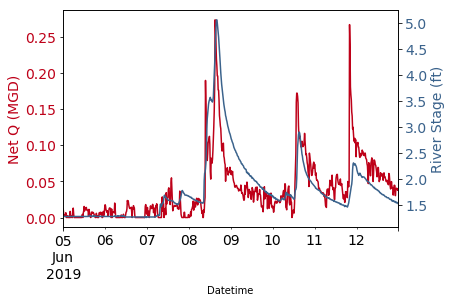

In [223]:
h = getTimeDiff(tStart.date() + dt.timedelta(days=1),tStart,returnState='hours')
m = getTimeDiff(tStart.date() + dt.timedelta(days=1),tStart,returnState='minutes')
h*60/15
list(range(0,len(wVals)))

dfflow['net'] = dfflow['Q (MGD)'].values - meanFlow.values
mask = dfflow['net']<0
dfflow.loc[mask,'net'] = 0

fig,ax = plt.subplots()

ax.set_ylabel('Net Q (MGD)',color='xkcd:scarlet',
               rotation='vertical',fontsize=14)
ax.tick_params(axis='y',labelcolor='xkcd:scarlet')
dfflow['net'].plot(kind='line',ax=ax,fontsize=14,color='xkcd:scarlet')

ax2 = ax.twinx()
ax2.set_ylabel('River Stage (ft)',color='xkcd:denim',
               rotation='vertical',fontsize=14)
ax2.tick_params(axis='y',labelcolor='xkcd:denim')
dfriver['river elevation'].plot(kind='line',ax=ax2,fontsize=14,color='xkcd:denim')
ax2.set_xlabel('Date')

In [224]:
y = dfflow['Q (MGD)'].values - meanFlow.values

Text(0, 0.5, 'Sewer (MGD)')

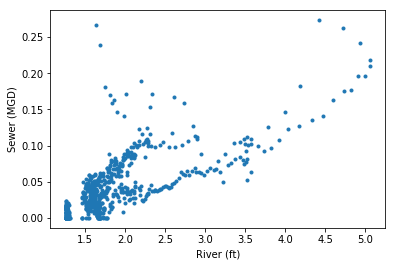

In [228]:
x = dfriver['river elevation'].values
y = dfflow['net']
cv = range(0,len(dfflow.index))

fig,ax = plt.subplots()
ax.plot(x,y,'.')
ax.set_xlabel('River (ft)')
ax.set_ylabel('Sewer (MGD)')

In [251]:
len(dfflow.index)/96
import numpy as np
np.linspace(dfflow.index[0].day,dfflow.index[-1].day,
            len(dfflow.index))

array([ 5.        ,  5.00912647,  5.01825293,  5.0273794 ,  5.03650587,
        5.04563233,  5.0547588 ,  5.06388527,  5.07301173,  5.0821382 ,
        5.09126467,  5.10039113,  5.1095176 ,  5.11864407,  5.12777053,
        5.136897  ,  5.14602347,  5.15514993,  5.1642764 ,  5.17340287,
        5.18252934,  5.1916558 ,  5.20078227,  5.20990874,  5.2190352 ,
        5.22816167,  5.23728814,  5.2464146 ,  5.25554107,  5.26466754,
        5.273794  ,  5.28292047,  5.29204694,  5.3011734 ,  5.31029987,
        5.31942634,  5.3285528 ,  5.33767927,  5.34680574,  5.3559322 ,
        5.36505867,  5.37418514,  5.3833116 ,  5.39243807,  5.40156454,
        5.410691  ,  5.41981747,  5.42894394,  5.4380704 ,  5.44719687,
        5.45632334,  5.4654498 ,  5.47457627,  5.48370274,  5.4928292 ,
        5.50195567,  5.51108214,  5.5202086 ,  5.52933507,  5.53846154,
        5.54758801,  5.55671447,  5.56584094,  5.57496741,  5.58409387,
        5.59322034,  5.60234681,  5.61147327,  5.62059974,  5.62

In [263]:
type(dfflow.index[0].day)
monthDict = {1: 'Jan',
            2: 'Feb',
            3: 'March',
            4: 'April',
            5: 'May',
            6: 'June',
            7: 'July',
            8: 'Aug',
            9: 'Sep',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec',}

seasonDict = {1: 'winter',
            2: 'winter',
            3: 'spring',
            4: 'spring',
            5: 'spring',
            6: 'summer',
            7: 'summer',
            8: 'summer',
            9: 'summer',
            10: 'winter',
            11: 'winter',
            12: 'winter',}

seasonClrM = {'winter' : 'GnBu',
            'spring' : 'RdPu',
            'summer': 'YlOrRd'}

seasonClr = {'winter' : 'ckcd:turquoise',
            'spring' : 'xkcd:pinkish purple',
            'summer': 'xkcd:scarlet'}

Text(0.5, 1.0, 'BC03')

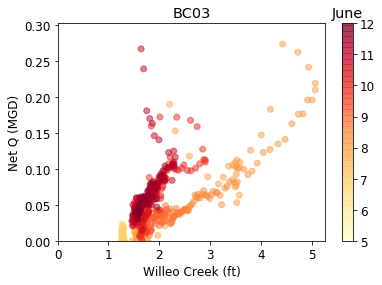

In [273]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})

fig,ax = plt.subplots()
cv = np.linspace(dfflow.index[0].day,dfflow.index[-1].day,
            len(dfflow.index))
colormap = seasonClrM[seasonDict[dfflow.index[0].month]]
plt.scatter(x,y,c=cv,cmap=colormap,alpha=0.5)
cb = plt.colorbar()
cb.ax.set_title(monthDict[dfflow.index[0].month])

ax.set_xlabel('Willeo Creek (ft)')
ax.set_xlim(left=0)
ax.set_ylabel('Net Q (MGD)')
ax.set_ylim(bottom=0)
ax.set_title(fmname)

In [304]:
filename='H:\\Big Creek\\USGS River\\Nov12th\\USGS02335450_15min_20181110-20181116.txt'
df = pd.read_csv(filename, sep='	',header=27,index_col=2)
df.head()

,agency_cd,site_no,tz_cd,39526_00060,39526_00060_cd,39527_00065,39527_00065_cd
datetime,,,,,,,
20d,5s,15s,6s,14n,10s,14n,10s
2018-11-10 00:00,USGS,02335450,EST,2760,A,4.63,A
2018-11-10 00:15,USGS,02335450,EST,2790,A,4.65,A
2018-11-10 00:30,USGS,02335450,EST,2840,A,4.68,A
2018-11-10 00:45,USGS,02335450,EST,2890,A,4.71,A


In [283]:
df = pd.read_csv(filename,sep='	',header=29)
df.head()

# 
agency_cd site_no  datetime         tz_cd 247744_00045 247744_00045_cd 39546_00062  39546_00062_cd
5s        15s      20d              6s    14n          10s             14n                     10s
USGS      02335810 2018-04-21 00:00 EDT   NaN          NaN             865.47                    A
                   2018-04-21 00:15 EDT   NaN          NaN             865.45                    A
                   2018-04-21 00:30 EDT   NaN          NaN             865.44                    A